In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
ticker="AAPL"
period="10y"
interval ="5d"
call_premium=5.0
put_premium=5.0


def extract_adjclose(df, ticker=None):
    """
    Return a pandas Series named 'AdjClose' from a yfinance DataFrame
    regardless of single- vs multi-index columns.
    """
    import pandas as pd

    # Case 1: MultiIndex columns (e.g., ('Close','AAPL'))
    if isinstance(df.columns, pd.MultiIndex):
        # Try exact (level0, level1) match if ticker is known
        if ticker is not None:
            for key in [("Adj Close", ticker), ("Close", ticker)]:
                if key in df.columns:
                    s = df[key].dropna().rename("AdjClose")
                    return s
        # Fallback: take the first available under level0 'Adj Close' or 'Close'
        for top in ("Adj Close", "Close"):
            if top in df.columns.get_level_values(0):
                s = df[top].iloc[:, 0].dropna().rename("AdjClose")
                return s

    # Case 2: Regular columns
    for col in ("Adj Close", "Close", "AdjClose", "close", "adjclose"):
        if col in df.columns:
            s = df[col].dropna().rename("AdjClose")
            return s

    # If we reach here, nothing matched
    raise SystemExit(f"Couldn't find a Close/Adj Close column. Got columns: {list(df.columns)}")

# ---- use it like this ----
data = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
if data.empty:
    raise SystemExit("No data returned—check ticker/period/internet.")

prices = extract_adjclose(data, ticker)
print(prices)

Date
2015-09-30     24.787230
2015-10-05     24.895100
2015-10-15     25.137802
2015-10-20     25.567028
2015-10-30     26.854708
                 ...    
2025-09-02    229.720001
2025-09-12    234.070007
2025-09-17    238.990005
2025-09-22    256.079987
2025-09-29    254.429993
Name: AdjClose, Length: 503, dtype: float64


In [39]:
simple_ret=prices.pct_change().dropna().rename("simple_return")
log_ret=np.log(prices/prices.shift(1)).dropna().rename("log_return")
out = pd.concat([prices, simple_ret, log_ret], axis=1)
out.to_csv(f"{ticker}_level-1.csv", index=True)


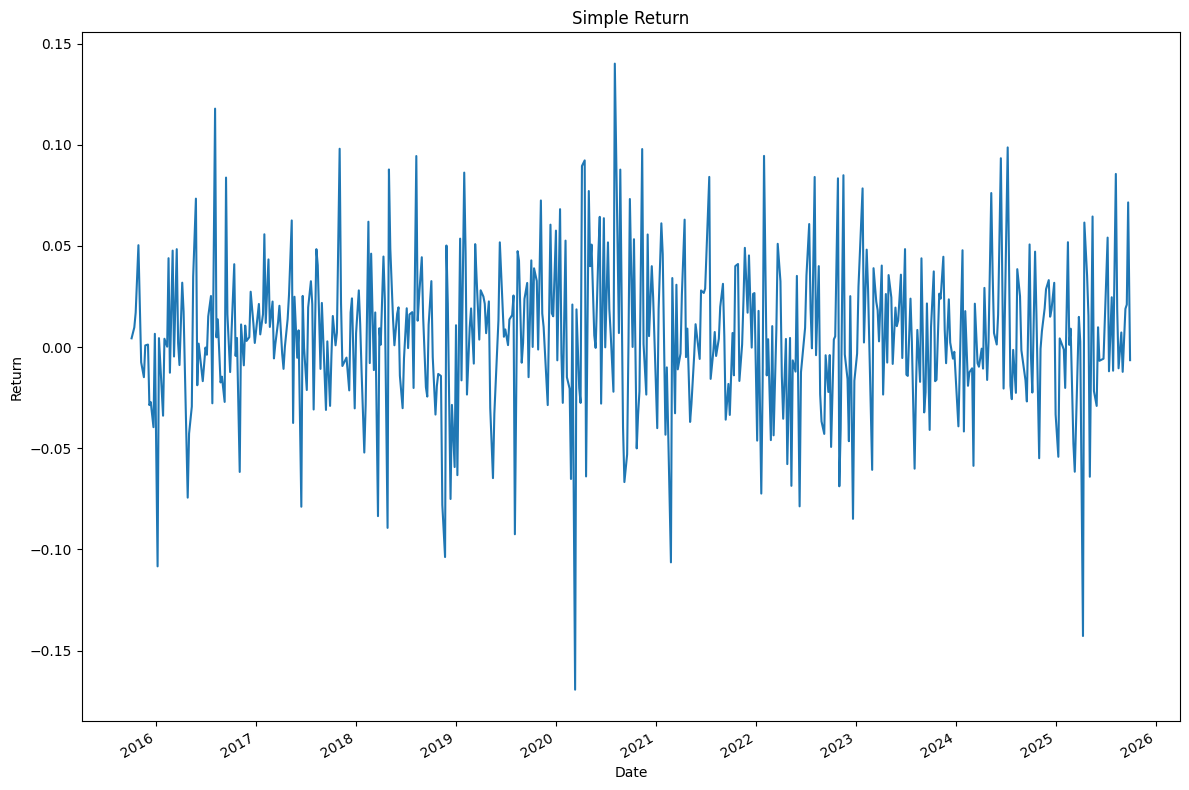

In [40]:
plt.figure(figsize=(12, 8))
simple_ret.plot()
plt.title("Simple Return")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
plt.show()

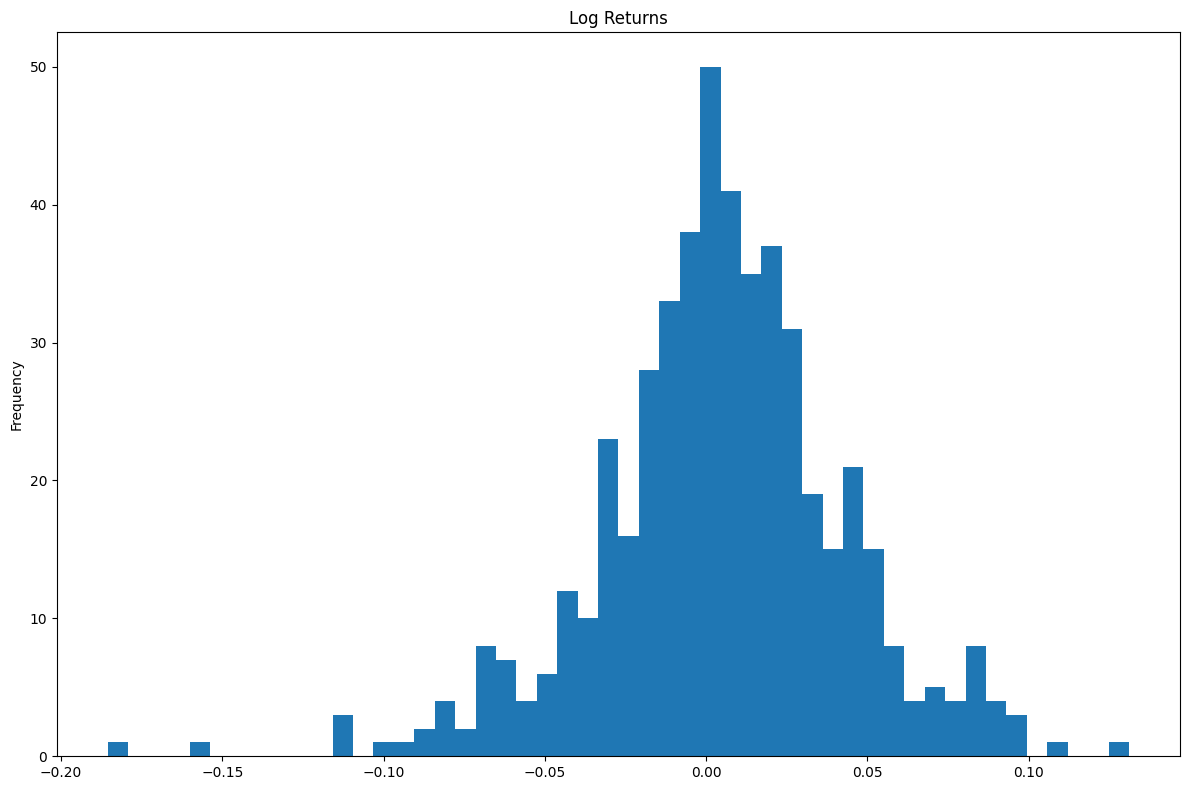

In [41]:
plt.figure(figsize=(12, 8))
log_ret.plot(kind="hist",bins=50)
plt.title("Log Returns")
plt.tight_layout()
plt.show()

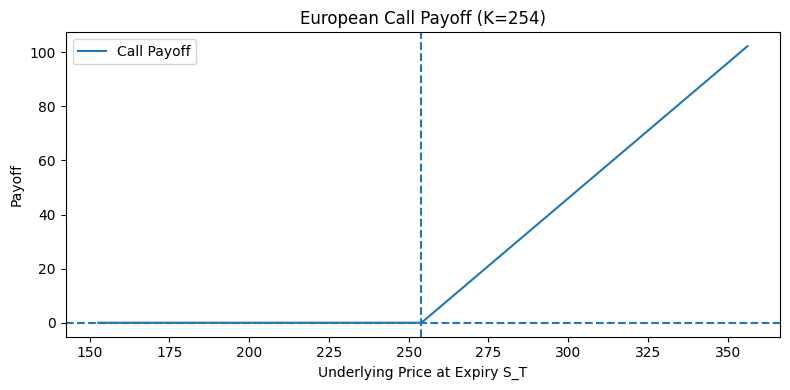

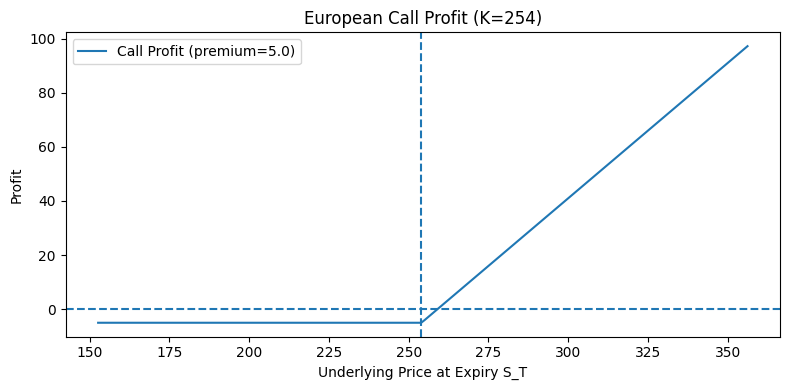

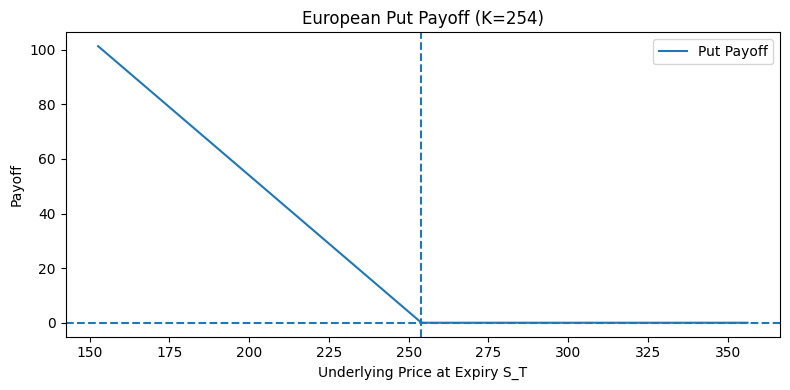

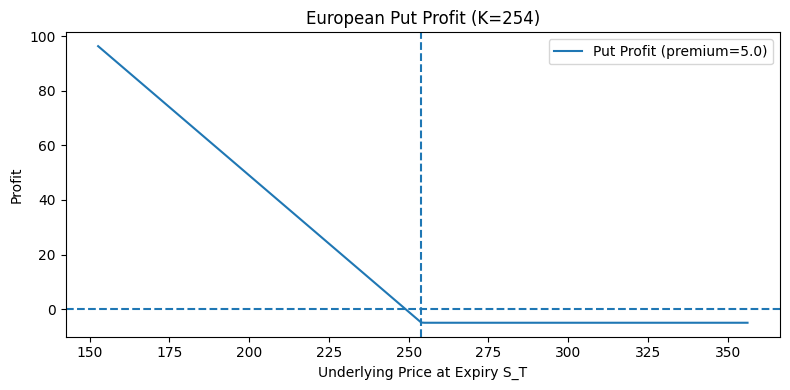

In [45]:
# payoff/profit arrays for a European call & put
S0=prices.iloc[-1]
K=round(float(S0))


S_T=np.linspace(0.6*S0,1.4*S0,200)
call_payoff=np.maximum(S_T-K,0.0)
put_payoff=np.maximum(K-S_T,0.0)

call_profit=call_payoff-call_premium

put_profit=put_payoff-put_premium
plt.figure(figsize=(8,4))
plt.plot(S_T, call_payoff, label="Call Payoff")
plt.axvline(K, linestyle="--"); plt.axhline(0, linestyle="--")
plt.title(f"European Call Payoff (K={K})")
plt.xlabel("Underlying Price at Expiry S_T"); plt.ylabel("Payoff")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(S_T, call_profit, label="Call Profit (premium={})".format(call_premium))
plt.axvline(K, linestyle="--"); plt.axhline(0, linestyle="--")
plt.title(f"European Call Profit (K={K})")
plt.xlabel("Underlying Price at Expiry S_T"); plt.ylabel("Profit")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(S_T, put_payoff, label="Put Payoff")
plt.axvline(K, linestyle="--"); plt.axhline(0, linestyle="--")
plt.title(f"European Put Payoff (K={K})")
plt.xlabel("Underlying Price at Expiry S_T"); plt.ylabel("Payoff")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(S_T, put_profit, label="Put Profit (premium={})".format(put_premium))
plt.axvline(K, linestyle="--"); plt.axhline(0, linestyle="--")
plt.title(f"European Put Profit (K={K})")
plt.xlabel("Underlying Price at Expiry S_T"); plt.ylabel("Profit")
plt.legend(); plt.tight_layout(); plt.show()

In [46]:
print(f"Saved returns to {ticker}_step1_returns.csv")
print(f"Spot S0={S0:.2f}, Strike K={K}, Call breakeven ≈ {K+call_premium:.2f}, Put breakeven ≈ {K-put_premium:.2f}")

Saved returns to AAPL_step1_returns.csv
Spot S0=254.43, Strike K=254, Call breakeven ≈ 259.00, Put breakeven ≈ 249.00
